In [68]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

from pathlib import Path
import re

YOLO_TRAIN_DIR = Path("/home/lex/data/Spatial_Monitoring_and_Insect_Behavioural_Analysis_Dataset/YOLOv4_Training_and_Test_Dataset/training")
YOLO_TEST_DIR = Path("/home/lex/data/Spatial_Monitoring_and_Insect_Behavioural_Analysis_Dataset/YOLOv4_Training_and_Test_Dataset/testing")
CLASSIFIER_TRAIN_DIR = Path("out/classification/training")
CLASSIFIER_TEST_DIR = Path("out/classification/testing")

CLASSIFIER_TRAIN_DIR.mkdir(parents=True, exist_ok=True)
CLASSIFIER_TEST_DIR.mkdir(parents=True, exist_ok=True)

INSECT_TXT_REGEX = re.compile(r"insect_(\d+).txt")

TRAIN = "train"
TEST = "test"

In [98]:
# Get list of target classes (e.g. bee/wasp, flower, etc.) and corresponding zero-based index for that class
TARGET_TO_NAME = pd.Series(
    {
        0: "honeybee_vespidae", 
        1: "flower", 
        2: "syrphidae", 
        3: "lepidoptera"
    }, 
    name="target_name"
)
NAME_TO_TARGET = {v: k for k, v in TARGET_TO_NAME.items()}
TARGET_TO_NAME

0    honeybee_vespidae
1               flower
2            syrphidae
3          lepidoptera
Name: target_name, dtype: object

In [70]:
# Get DataFrame where each row corresponds to a unique image+bounding box for every
# instance of an insect that occurs in the (full-resolution) training images
csv_columns = ["target", "centre_x", "centre_y", "box_width", "box_height"]
extra_columns = ["image"]

dataframes = {
    "train": pd.DataFrame(columns=[*extra_columns, *csv_columns]),
    "test": pd.DataFrame(columns=[*extra_columns, *csv_columns])
}

for directory, phase in zip([YOLO_TRAIN_DIR, YOLO_TEST_DIR], [TRAIN, TEST]):
    for file in directory.iterdir():
        match = INSECT_TXT_REGEX.match(file.name)
        if match:
            row = pd.read_csv(file, sep=" ", names=csv_columns)
            
            # Get corresponding image for this insect 
            image_fp = file.with_suffix(".png")
            row["image"] = str(image_fp)

            dataframes[phase] = pd.concat([dataframes[phase], row], ignore_index=True)

dataframes["train"].head()

,image,target,centre_x,centre_y,box_width,box_height
0,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,0.438305,0.512250,0.016172,0.033593
1,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,0.131612,0.412750,0.011568,0.035130
2,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,0.394792,0.306481,0.017708,0.025926
3,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,0.294792,0.488889,0.030208,0.055556
4,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,0.514062,0.241204,0.038542,0.065741


In [71]:
# Add insect type as human-friendly string to dataframe just because
for phase in [TRAIN, TEST]:
    dataframes[phase] = dataframes[phase].join(TARGET_TO_NAME, on="target")

dataframes[TRAIN].head()

,image,target,centre_x,centre_y,box_width,box_height,target_name
0,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,0.438305,0.512250,0.016172,0.033593,honeybee_vespidae
1,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,0.131612,0.412750,0.011568,0.035130,honeybee_vespidae
2,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,0.394792,0.306481,0.017708,0.025926,honeybee_vespidae
3,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,0.294792,0.488889,0.030208,0.055556,flower
4,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,0.514062,0.241204,0.038542,0.065741,flower


In [72]:
def crop_to_insect(image: np.ndarray, centre_x: int, centre_y: int, height_width:int=128):
    """Convert a row from our insect bounding boxes DataFrame into a cropped image."""
    # Note we're not actually using the original height/width of bounding boxes, 
    # we want something a little less precise and more consistent
    top_y = int(centre_y - 0.5 * height_width)
    bottom_y = int(centre_y + 0.5 * height_width)
    left_x = int(centre_x - 0.5 * height_width)
    right_x = int(centre_x + 0.5 * height_width)

    height, width, channels = image.shape

    # print(f"Before, top_y={top_y}, bottom_y={bottom_y}, left_x={left_x}, right_x={right_x}")
    # Check if our crop goes out of bounds
    pad_width = [[0, 0], [0, 0], [0, 0]] # padding width for (before, after) for each axis of image arrays
    if top_y < 0:
        pad_width[0][0] = abs(top_y)
        bottom_y += abs(top_y)
        top_y = 0
    if bottom_y > height:
        pad_width[0][1] = abs(bottom_y - height) + 1
    if left_x < 0:
        pad_width[1][0] = abs(left_x)
        right_x += abs(left_x)
        left_x = 0
    if right_x > width:
        pad_width[1][1] = abs(right_x - width) + 1
    # print(f"After, top_y={top_y}, bottom_y={bottom_y}, left_x={left_x}, right_x={right_x}")

    image_padded = np.pad(image, pad_width=pad_width, mode="symmetric")
    image_cropped = image_padded[top_y:bottom_y, left_x:right_x]

    return image_cropped

In [73]:
# Make sure our output directories exist before we put files into them
for target in TARGET_TO_NAME:
    print(f"Creating training/ and testing/ directories for '{target}' in '{CLASSIFIER_TRAIN_DIR}' and '{CLASSIFIER_TEST_DIR}', respectively")
    (CLASSIFIER_TRAIN_DIR / target).mkdir(parents=True, exist_ok=True)
    (CLASSIFIER_TEST_DIR / target).mkdir(parents=True, exist_ok=True)

Creating training/ and testing/ directories for 'honeybee_vespidae' in 'out/classification/training' and 'out/classification/testing', respectively
Creating training/ and testing/ directories for 'flower' in 'out/classification/training' and 'out/classification/testing', respectively
Creating training/ and testing/ directories for 'syrphidae' in 'out/classification/training' and 'out/classification/testing', respectively
Creating training/ and testing/ directories for 'lepidoptera' in 'out/classification/training' and 'out/classification/testing', respectively


In [74]:
# Now convert those fractional positions above to absolute pixel values (e.g. 
# centre_x=0.44 --> 0.44*1920~=845)
for phase, input_dir, output_dir in zip([TRAIN, TEST], [YOLO_TRAIN_DIR, YOLO_TEST_DIR], [CLASSIFIER_TRAIN_DIR, CLASSIFIER_TEST_DIR]):
    df = dataframes[phase]

    # We'll store these back into the dataframe to store the integer, not fractional,
    # measurements. All images are probably the same resolution, but do it this
    # way just in case there are differing resolutions
    centre_ys = pd.Series(index=df.index, name="centre_y", dtype=int)
    centre_xs = pd.Series(index=df.index, name="centre_x", dtype=int)
    box_heights = pd.Series(index=df.index, name="box_height", dtype=int)
    box_widths = pd.Series(index=df.index, name="box_width", dtype=int)
    image_heights = pd.Series(index=df.index, name="image_height", dtype=int)
    image_widths = pd.Series(index=df.index, name="image_width", dtype=int)
    
    for index, row in tqdm(df.iterrows(), total=len(df), desc=phase):
        row = row.squeeze()

        input_fp = input_dir / row["image"]
        image = cv2.imread(str(input_fp))
        image_height, image_width, num_channels = image.shape

        # Store conversions from fractional to absolute values for later reuse
        centre_y = int(row["centre_y"] * image_height)
        centre_x = int(row["centre_x"] * image_width)
        box_height = int(row["box_height"] * image_height)
        box_width = int(row["box_width"] * image_width)

        # Crop image and save to output directory
        image_cropped = crop_to_insect(image=image, centre_x=centre_x, centre_y=centre_y)

        input_stem = input_fp.stem
        input_suffix = input_fp.suffix
        target_name = row["target_name"]
        
        output_name = f"{input_stem}_{row['target']}_{centre_x}_{centre_y}{input_suffix}"
        output_fp = output_dir / target_name / output_name
        # print(output_fp)
        
        cv2.imwrite(str(output_fp), image_cropped)

        # Save these as integers, maybe for later
        centre_ys[index] = centre_y
        centre_xs[index] = centre_x
        box_heights[index] = box_height
        box_widths[index] = box_width
        image_heights[index] = image_height
        image_widths[index] = image_width
    
    dataframes[phase] = df.assign(
        centre_y=centre_ys,
        centre_x=centre_xs,
        box_height=box_heights,
        box_width=box_widths,
        image_height=image_heights,
        image_width=image_widths
    )
    dataframes[phase] = dataframes[phase].astype({
        "centre_y": int,
        "centre_x": int,
        "box_height": int,
        "box_width": int,
        "image_height": int,
        "image_width": int
    })
    
    
dataframes[TRAIN].head()

test: 100%|██████████| 3246/3246 [02:32<00:00, 21.28it/s]


,image,target,centre_x,centre_y,box_width,box_height,target_name,image_height,image_width
0,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,841,553,31,36,honeybee_vespidae,1080,1920
1,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,252,445,22,37,honeybee_vespidae,1080,1920
2,/home/lex/data/Spatial_Monitoring_and_Insect_B...,0,758,330,33,28,honeybee_vespidae,1080,1920
3,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,566,528,57,60,flower,1080,1920
4,/home/lex/data/Spatial_Monitoring_and_Insect_B...,1,986,260,74,71,flower,1080,1920


  0%|          | 2/2997 [00:04<1:53:55,  2.28s/it]


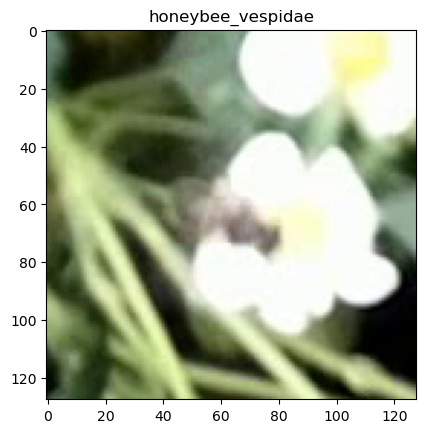

In [119]:
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision.datasets.folder import default_loader
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

import time
from typing import Tuple, List, Dict, Optional, Callable, Any
import os


class MyDataLoader(ImageFolder):
    def __init__(self, root: str):
        super().__init__(root)

    def find_classes(self, directory: str) -> Tuple[List[str], Dict[str, int]]:
        """Finds the class folders in a dataset.

        See :class:`DatasetFolder` for details.
        """
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Couldn't find any class folder in {directory}.")

        classes.remove("flower")

        class_to_idx = {cls_name: NAME_TO_TARGET[cls_name] for cls_name in classes}
        return classes, class_to_idx


# # class_to_idx = {v: k for k, v in TARGET_TO_NAME.items()}
# # dataloader = DatasetFolder(directory=CLASSIFIER_TRAIN_DIR, class_to_idx=class_to_idx, loader=default_loader)
dataloader = MyDataLoader(root=CLASSIFIER_TRAIN_DIR)
num_data = len(dataloader)
sampler = SubsetRandomSampler(indices=range(num_data))

bee_index = TARGET_TO_NAME.index[TARGET_TO_NAME == "honeybee_vespidae"][0]

for index in tqdm(sampler, total=num_data):
    image, target = dataloader[index]
    # if target == bee_index:
    try:
        plt.imshow(image, cmap="gray")
        plt.title(TARGET_TO_NAME[target])
        display.display(plt.gcf())
        display.clear_output(wait=True)
        if input("q to exit: ") == "q":
            break
    except KeyboardInterrupt:
        break